In [1]:
####################################
#
# generateAdversarials: This code will load a pre-trained model, sample validation data
#                       and find adversarial inputs.
#
# Method: Let the input to the forcaster be X and the target be y
#         Note that both X & y are real valued
#         We find X' such that X' ~ X and |y'-y| >> 0
#         We will adapt the optimisation method of Carlini & Wagner
#         for the generation of the adversarials
#
# Author: Anurag Dwarakanath
###################################

In [43]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Constants
DATAFILE_VALIDATE = "mock_kaggle_edit_validate.csv"

TRAINED_MODEL_PATH = 'savedModel'

TIME_STEPS = 10 # i.e. look at the past 10 days and forecast
NUMBER_OF_DAYS_TO_FORECAST = 1 # for now we will only forecast the next day's sales

BATCH_SIZE=100

LEARNING_RATE = 0.1

In [4]:
#Load the validation data
rawData = pandas.read_csv(DATAFILE_VALIDATE)
validationSales=rawData['sales']

In [5]:
#We need to normalise the data
MIN = 0
RANGE = 542
validationSalesNormalised = [(i-MIN)/RANGE for i in validationSales]

In [6]:
#Create the sequences
validationSalesSequences = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, TIME_STEPS, 1))
validationSalesTargets = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, NUMBER_OF_DAYS_TO_FORECAST))

for i in range(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1):
    validationSalesSequences[i,:,0] = validationSalesNormalised[i:i+TIME_STEPS]
    validationSalesTargets[i,:] = validationSalesNormalised[i+TIME_STEPS:i+TIME_STEPS+NUMBER_OF_DAYS_TO_FORECAST]

In [7]:
#create the data structure to hold the perturbations
perturbedSequences = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, TIME_STEPS, 1))
perturbedForecasts = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, NUMBER_OF_DAYS_TO_FORECAST))
originalForecasts = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, NUMBER_OF_DAYS_TO_FORECAST))

inputSequenceLosses = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, NUMBER_OF_DAYS_TO_FORECAST))
forecastLosses = np.zeros(shape=(len(validationSales)-TIME_STEPS - NUMBER_OF_DAYS_TO_FORECAST + 1, NUMBER_OF_DAYS_TO_FORECAST))

In [16]:
#We now load the pre-trained graph
tf.reset_default_graph()

with tf.Session() as sess:
    
    perturbVariables=tf.get_variable(name='pVar', shape=(BATCH_SIZE, TIME_STEPS, 1), dtype=tf.float32)
    #perturbVariables=tf.Variable(name='pVar', initial_value=np.zeros(size=(None, TIME_STEPS, 1)), dtype=tf.float32, validate_shape=False)
    perturbedSequence = tf.math.square(x=perturbVariables) # We want the perturbed Sequence to always be positive.

    actualValidationInputSequence = tf.placeholder(name='aInp', shape=(None, TIME_STEPS, 1), dtype=tf.float32)
    #actualValidationTarget = tf.placeholder(name='aTar', shape=(None, NUMBER_OF_DAYS_TO_FORECAST), dtype=tf.float32)
    
    sess.run(tf.variables_initializer([perturbVariables]))
    
    print('Loading the model from:', TRAINED_MODEL_PATH)
    tf.saved_model.loader.load(sess=sess, export_dir=TRAINED_MODEL_PATH, tags=[tag_constants.SERVING], input_map={'inputSequencePlaceholder:0':perturbedSequence})
    
    #inputSequence = tf.get_default_graph().get_tensor_by_name('inputSequencePlaceholder:0')
    forecast_normalisedScale = tf.get_default_graph().get_tensor_by_name('forecast_normalised_scale:0')
    forecast_originalScale = tf.get_default_graph().get_tensor_by_name('forecast_original_scale:0')
    targetForecast = tf.get_default_graph().get_tensor_by_name('targetPlaceholder:0')
    
    minLoss = 1000
    minLossSequenceID=-1
    #loop through all the validation sequences
    start=0
    end=0
    numIterations = np.int(np.ceil(len(validationSalesTargets)/BATCH_SIZE))
    print(numIterations)
    currentSequence = np.zeros(shape=(BATCH_SIZE, TIME_STEPS, 1))
    for i in range(numIterations):
        
        print('Starting Batch:', i)
        start=i*BATCH_SIZE
        if (start+BATCH_SIZE < len(validationSalesTargets)):
            end=start+BATCH_SIZE
        else:
            end=len(validationSalesTargets)

        #get the forecast for the current inputSeqeunce
        currentSequence[0:end-start] = validationSalesSequences[start:end]
            
        #initialise perturbVariables with the actual values received.
        assignValue = tf.assign(ref=perturbVariables, value=currentSequence)
        sess.run(assignValue)
    
        #Get the forecasts for the actual values
        tarFor = sess.run(forecast_originalScale)
        print(forecast_originalScale)
    
        print('current 2 Forecast for sequence number ', i, 'is: ', tarFor[0:2])
    
        #random initialisation of perturbed Variables
        #assignValue = tf.assign(ref=perturbVariables, value=currentSequence)# + np.random.normal(size=(1, TIME_STEPS, 1)))
        #sess.run(assignValue)
    
        #inputSequenceLoss = tf.nn.l2_loss(t=(perturbedSequence - currentSequence))
        inputSequenceLoss = tf.math.reduce_sum(input_tensor=tf.math.square(perturbedSequence - currentSequence), axis=1)
        #inputSequenceLoss = tf.math.reduce_max(input_tensor=tf.math.abs(perturbVar - currentSequence))
        #forecastLoss = 1/(tf.losses.mean_squared_error(labels=forecast_originalScale, predictions=tarFor) + 0.00001)
        #forecastLoss = -tf.math.log(tf.math.abs(forecast_originalScale - tarFor)/tf.math.abs(forecast_originalScale))
        forecastLoss =  tf.math.square(forecast_originalScale - 2*tarFor)
    
        totalLoss = 1000* inputSequenceLoss + 1 * forecastLoss
    
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
        trainStep = optimizer.minimize(totalLoss, var_list=[perturbVariables])
    
        all_variables = tf.all_variables()
        is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in all_variables])
        not_initialized_vars = [v for (v, f) in zip(all_variables, is_not_initialized) if not f]
        sess.run(tf.variables_initializer(not_initialized_vars))    
    
        for optStep in range(200):
            _, perturbedInput, forecastForPerturbedInput, inpSeqLoss, forLoss = sess.run([trainStep, perturbedSequence, forecast_originalScale, inputSequenceLoss, forecastLoss])
    

        #save the values
        perturbedSequences[start:end] = (perturbedInput[0:end-start] * RANGE) + MIN
        perturbedForecasts[start:end] = forecastForPerturbedInput[0:end-start]
        inputSequenceLosses[start:end] = inpSeqLoss[0:end-start]
        forecastLosses[start:end] = forLoss[0:end-start]
        originalForecasts[start:end] = tarFor[0:end-start]
        
        if np.min(inpSeqLoss) < minLoss :
            minLoss = np.min(inpSeqLoss)
            minLossSequenceID = start+np.argmin(inpSeqLoss)
        
        start+=BATCH_SIZE
    
    print('Mininum sequence loss:', inputSequenceLosses[minLossSequenceID])
    print('Perturbed sequence:',perturbedSequences[minLossSequenceID])
    print('Original Sequence:', (validationSalesSequences[minLossSequenceID] * RANGE ) + MIN )
    print('Original Forecast:', originalForecasts[minLossSequenceID])
    print('Perturbed Forecast:', perturbedForecasts[minLossSequenceID])
    print('Actual target:',(validationSalesTargets[minLossSequenceID]*RANGE) + MIN )
    print('--------')
    
    
    

Loading the model from: savedModel
INFO:tensorflow:Restoring parameters from savedModel\variables\variables
2
Starting Batch: 0
Tensor("forecast_original_scale:0", shape=(?, 1), dtype=float32)
current 2 Forecast for sequence number  0 is:  [[57.43527 ]
 [46.846264]]
Starting Batch: 1
Tensor("forecast_original_scale:0", shape=(?, 1), dtype=float32)
current 2 Forecast for sequence number  1 is:  [[33.79866 ]
 [36.176975]]
Mininum sequence loss: [1.19921629e-06]
Perturbed sequence: [[ 77.97800446]
 [121.97356415]
 [164.01097107]
 [288.0302124 ]
 [138.03642273]
 [188.99427795]
 [320.95986938]
 [209.05773926]
 [161.01622009]
 [157.58609009]]
Original Sequence: [[ 78.]
 [122.]
 [164.]
 [288.]
 [138.]
 [189.]
 [321.]
 [209.]
 [161.]
 [157.]]
Original Forecast: [73.00727081]
Perturbed Forecast: [146.01014709]
Actual target: [283.]
--------


In [74]:
#Generating the maximum amount of perturbation needed to double the forecast.
# m will hold the maximum change needed in any time dimension for each of the input sequence
m = np.max(np.abs(perturbedSequences - (validationSalesSequences * RANGE ) + MIN), axis=1 )


(array([10.,  7.,  6.,  3., 32., 53., 24.]),
 array([ 1,  2,  3,  4,  5, 10, 20, 30]),
 <a list of 7 Patch objects>)

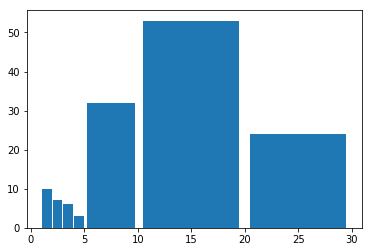

In [80]:
# We now plot the histogram

plt.hist(m, bins=[1, 2, 3, 4, 5, 10, 20, 30], rwidth=0.9)

In [ ]:
# That's all folks.